In [1]:
# There is a World Happiness Report dataset on Kaggle that provides "happiness ratings" 
# for a number of countries throughtout the world. These data were collected through the Gallup
# World Poll. The columns following the happiness score estimate the extent to which each 
# of six factors – economic production, social support, health, freedom, 
# absence of corruption, and generosity – contribute to making life evaluations higher 
# in each country. 
# I was interesting in investigating the relationship between these happiness scores for each 
# country and several other factors: namely, life expectancies, annual hours spent at work, &
# religiosity per country. 
# Life expectancy data was provided by the WHO. Annual hours worked was provided by OECD. Note 
# that these employment data are coming only from a small number of countries (37). I could 
# not find data on annual hours worked from other (developing) nations. 
# Religiosity data provided by WIN-Gallup International Global Index of Religiosity 
# and Atheism-2012

In [71]:
import pandas as pd
import numpy as np
import scipy.stats
import statsmodels.formula.api as smf
from scipy.stats.mstats import zscore
#import statsmodels.api as sm

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

pd.set_option('max_columns', 60)
%matplotlib inline

import warnings

In [3]:
#import data from cvs files:
#happiness scores:
happiness_scores_2017 = pd.read_csv('/Users/saraszczepanski/Documents/python_work/world_happiness/2017.csv')
happiness_scores_2016 = pd.read_csv('/Users/saraszczepanski/Documents/python_work/world_happiness/2016.csv')
happiness_scores_2015 = pd.read_csv('/Users/saraszczepanski/Documents/python_work/world_happiness/2015.csv')

#WHO life expectencies:
life_expectancies = pd.read_csv('/Users/saraszczepanski/Documents/python_work/world_happiness/WHO_life_expectancies.csv')

#annual hours per work per country (for OECD countries only):
annual_hours_worked = pd.read_csv('/Users/saraszczepanski/Documents/python_work/world_happiness/annual_hours_per_worker_OECD.csv')

#global religiosity per country:
global_religiosity_2012 = pd.read_csv('/Users/saraszczepanski/Documents/python_work/world_happiness/Global_religiosity.csv')

In [4]:
#first, let's get happiness score data into a format we can use:
happiness_scores_2015.head()
#Notice that the top 5 countries with the highest happiness scores are all western countries,
#located in the north. The also all happen to be social democracies. 

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health,Freedom,Trust (Government Corruption),Generosity,Dystopia Residual
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201
2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204
3,Norway,Western Europe,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531
4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176


In [5]:
# add a new column ('color') to happiness_scores_2015. each geographic region will be 
# color-coded so that we can later visualize where each of these regions falls on the regression
# plots
happiness_scores_2015['Color'] = np.nan
for area in range(0,happiness_scores_2015['Region'].size):
    if happiness_scores_2015.Region[area] == 'North America':
        happiness_scores_2015.ix[area,['Color']] = '#2009ef' #(hex color- dark blue)
    elif happiness_scores_2015.Region[area] == 'Latin America and Caribbean':
        happiness_scores_2015.ix[area,['Color']] = '#0b94ef' #(hex color- light blue)
    elif happiness_scores_2015.Region[area] == 'Western Europe':
        happiness_scores_2015.ix[area,['Color']] = '#07f7e3' #(hex color- aqua)
    elif happiness_scores_2015.Region[area] == 'Central and Eastern Europe':
        happiness_scores_2015.ix[area,['Color']] = '#04f28f' #(hex color- light green)
    elif happiness_scores_2015.Region[area] == 'Middle East and Northern Africa':
        happiness_scores_2015.ix[area,['Color']] = '#08f404' #(hex color- green)
    elif happiness_scores_2015.Region[area] == 'Sub-Saharan Africa':
        happiness_scores_2015.ix[area,['Color']] = '#f2e604' #(hex color- yellow)
    elif happiness_scores_2015.Region[area] == 'Southern Asia':
        happiness_scores_2015.ix[area,['Color']] = '#f77402' #(hex color- orange)
    elif happiness_scores_2015.Region[area] == 'Southeastern Asia':
        happiness_scores_2015.ix[area,['Color']] = '#f93504' #(hex color- dark red)
    elif happiness_scores_2015.Region[area] == 'Eastern Asia':
        happiness_scores_2015.ix[area,['Color']]= '#fc02b5' #(hex color- pink)
    elif happiness_scores_2015.Region[area] == 'Australia and New Zealand':
        happiness_scores_2015.ix[area,['Color']] = '#a703f9' #(hex color- purple)
    else:
        warnings.warn('All of the regions must be labeled with a color!')


In [6]:
happiness_scores_2015

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health,Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Color
0,Switzerland,Western Europe,1,7.587,0.03411,1.39651,1.34951,0.94143,0.66557,0.41978,0.29678,2.51738,#07f7e3
1,Iceland,Western Europe,2,7.561,0.04884,1.30232,1.40223,0.94784,0.62877,0.14145,0.43630,2.70201,#07f7e3
2,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204,#07f7e3
3,Norway,Western Europe,4,7.522,0.03880,1.45900,1.33095,0.88521,0.66973,0.36503,0.34699,2.46531,#07f7e3
4,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176,#2009ef
5,Finland,Western Europe,6,7.406,0.03140,1.29025,1.31826,0.88911,0.64169,0.41372,0.23351,2.61955,#07f7e3
6,Netherlands,Western Europe,7,7.378,0.02799,1.32944,1.28017,0.89284,0.61576,0.31814,0.47610,2.46570,#07f7e3
7,Sweden,Western Europe,8,7.364,0.03157,1.33171,1.28907,0.91087,0.65980,0.43844,0.36262,2.37119,#07f7e3
8,New Zealand,Australia and New Zealand,9,7.286,0.03371,1.25018,1.31967,0.90837,0.63938,0.42922,0.47501,2.26425,#a703f9
9,Australia,Australia and New Zealand,10,7.284,0.04083,1.33358,1.30923,0.93156,0.65124,0.35637,0.43562,2.26646,#a703f9


In [7]:
#sort scores in alphabetical order, since other datasets are in alpha order:
happiness_scores_2015_alpha = happiness_scores_2015.sort_values('Country',axis=0)

In [8]:
happiness_scores_2015_alpha.head(20)

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health,Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Color
152,Afghanistan,Southern Asia,153,3.575,0.03084,0.31982,0.30285,0.30335,0.23414,0.09719,0.36510,1.95210,#f77402
94,Albania,Central and Eastern Europe,95,4.959,0.05013,0.87867,0.80434,0.81325,0.35733,0.06413,0.14272,1.89894,#04f28f
67,Algeria,Middle East and Northern Africa,68,5.605,0.05099,0.93929,1.07772,0.61766,0.28579,0.17383,0.07822,2.43209,#08f404
136,Angola,Sub-Saharan Africa,137,4.033,0.04758,0.75778,0.86040,0.16683,0.10384,0.07122,0.12344,1.94939,#f2e604
29,Argentina,Latin America and Caribbean,30,6.574,0.04612,1.05351,1.24823,0.78723,0.44974,0.08484,0.11451,2.83600,#0b94ef
126,Armenia,Central and Eastern Europe,127,4.350,0.04763,0.76821,0.77711,0.72990,0.19847,0.03900,0.07855,1.75873,#04f28f
9,Australia,Australia and New Zealand,10,7.284,0.04083,1.33358,1.30923,0.93156,0.65124,0.35637,0.43562,2.26646,#a703f9
12,Austria,Western Europe,13,7.200,0.03751,1.33723,1.29704,0.89042,0.62433,0.18676,0.33088,2.53320,#07f7e3
79,Azerbaijan,Central and Eastern Europe,80,5.212,0.03363,1.02389,0.93793,0.64045,0.37030,0.16065,0.07799,2.00073,#04f28f
48,Bahrain,Middle East and Northern Africa,49,5.960,0.05412,1.32376,1.21624,0.74716,0.45492,0.30600,0.17362,1.73797,#08f404


In [9]:
#There are 158 country entries:
happiness_scores_2015_alpha.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 158 entries, 152 to 114
Data columns (total 13 columns):
Country                          158 non-null object
Region                           158 non-null object
Happiness Rank                   158 non-null int64
Happiness Score                  158 non-null float64
Standard Error                   158 non-null float64
Economy (GDP per Capita)         158 non-null float64
Family                           158 non-null float64
Health                           158 non-null float64
Freedom                          158 non-null float64
Trust (Government Corruption)    158 non-null float64
Generosity                       158 non-null float64
Dystopia Residual                158 non-null float64
Color                            158 non-null object
dtypes: float64(9), int64(1), object(3)
memory usage: 17.3+ KB


In [10]:
#Next, let's get the life expectancy data into a format that we can use:
life_expectancies.head(30)

,Country,Year,Life_expectancy_birth(years)_both_sexes,Life_expectancy_birth(years)_male,Life_expectancy_birth(years)_female,Life_expectancy_at_60(years)_both_sexes,Life_expectancy_at_60(years)_male,Life_expectancy_at_60(years)_female
0,Afghanistan,2015,60.5,59.3,61.9,16.0,15.3,16.7
1,Afghanistan,2014,59.9,58.6,61.3,15.9,15.2,16.6
2,Afghanistan,2013,59.9,58.7,61.2,15.9,15.2,16.6
3,Afghanistan,2012,59.5,58.3,60.8,15.8,15.1,16.5
4,Afghanistan,2011,59.2,58.0,60.4,15.8,15.1,16.5
5,Afghanistan,2010,58.8,57.7,60.1,15.7,15.0,16.4
6,Afghanistan,2009,58.6,57.5,59.7,15.7,14.9,16.3
7,Afghanistan,2008,58.1,57.0,59.3,15.6,14.9,16.3
8,Afghanistan,2007,57.5,56.4,58.8,15.5,14.8,16.2
9,Afghanistan,2006,57.3,56.3,58.5,15.5,14.8,16.1


In [11]:
life_expectancies = life_expectancies.set_index(['Year'])

In [12]:
#Isolate year 2015, since this is the year closest to when the happiness data were collected
life_expectancies_2015 = life_expectancies.loc[2015]

In [13]:
life_expectancies_2015 = life_expectancies_2015.reset_index()

In [14]:
life_expectancies_2015.head(30)

,Year,Country,Life_expectancy_birth(years)_both_sexes,Life_expectancy_birth(years)_male,Life_expectancy_birth(years)_female,Life_expectancy_at_60(years)_both_sexes,Life_expectancy_at_60(years)_male,Life_expectancy_at_60(years)_female
0,2015,Afghanistan,60.5,59.3,61.9,16.0,15.3,16.7
1,2015,Albania,77.8,75.1,80.7,21.6,19.6,23.8
2,2015,Algeria,75.6,73.8,77.5,21.8,21.1,22.6
3,2015,Angola,52.4,50.9,54.0,15.8,15.1,16.3
4,2015,Antigua and Barbuda,76.4,74.1,78.6,21.7,20.2,23.0
5,2015,Argentina,76.3,72.7,79.9,21.5,18.8,23.8
6,2015,Armenia,74.8,71.6,77.7,19.6,17.6,21.2
7,2015,Australia,82.8,80.9,84.8,25.5,24.0,26.8
8,2015,Austria,81.5,79.0,83.9,24.1,22.2,25.9
9,2015,Azerbaijan,72.7,69.6,75.8,18.7,16.7,20.6


In [15]:
life_expectancies_2015_both_sexes = life_expectancies_2015[['Country','Life_expectancy_birth(years)_both_sexes']]

In [16]:
life_expectancies_2015_both_sexes.head(30)

,Country,Life_expectancy_birth(years)_both_sexes
0,Afghanistan,60.5
1,Albania,77.8
2,Algeria,75.6
3,Angola,52.4
4,Antigua and Barbuda,76.4
5,Argentina,76.3
6,Armenia,74.8
7,Australia,82.8
8,Austria,81.5
9,Azerbaijan,72.7


In [17]:
#there are 183 country entries:
len(life_expectancies_2015_both_sexes)

183

In [18]:
#The countries with the highest life expectancies:
life_expectancies_2015_both_sexes.sort_values('Life_expectancy_birth(years)_both_sexes',ascending=False).head()

,Country,Life_expectancy_birth(years)_both_sexes
81,Japan,83.7
158,Switzerland,83.4
144,Singapore,83.1
152,Spain,82.8
7,Australia,82.8


In [19]:
#The countries with the lowest life expectancies:
life_expectancies_2015_both_sexes.sort_values('Life_expectancy_birth(years)_both_sexes',ascending=True).head()

,Country,Life_expectancy_birth(years)_both_sexes
143,Sierra Leone,50.1
3,Angola,52.4
31,Central African Republic,52.5
32,Chad,53.1
40,Cote d'Ivoire,53.3


In [20]:
#Next, get annual hours worked 
annual_hours_worked.head()

,Country,Employment status,Year,Annual Hours
0,Australia,Total employment,2015,1665.0
1,Australia,Total employment,2014,1663.6
2,Australia,Total employment,2013,1662.7
3,Australia,Total employment,2012,1678.6
4,Australia,Total employment,2011,1699.5


In [21]:
#Isolate year 2015, since this is the year closest to when the happiness data were collected
annual_hours_worked_2015 = annual_hours_worked.set_index('Year').loc[2015]

In [22]:
#exclude Dependent Employment:
annual_hours_worked_2015_total_employ = annual_hours_worked_2015[annual_hours_worked_2015['Employment status'] == 'Total employment']

In [23]:
del annual_hours_worked_2015_total_employ['Employment status']

In [24]:
annual_hours_worked_2015_total_employ = annual_hours_worked_2015_total_employ.reset_index()

In [25]:
del annual_hours_worked_2015_total_employ['Year']

In [26]:
annual_hours_worked_2015_total_employ

,Country,Annual Hours
0,Australia,1665.000000
1,Austria,1624.900000
2,Belgium,1541.000000
3,Canada,1706.000000
4,Chile,1987.500000
5,Costa Rica,2230.100000
6,Czech Republic,1779.000000
7,Denmark,1457.000000
8,Estonia,1852.000000
9,Finland,1646.000000


In [27]:
#There are 38 (-OECD countries) entries. 
len(annual_hours_worked_2015_total_employ)

39

In [28]:
#The countries that work the most hours per year:
annual_hours_worked_2015_total_employ.sort_values('Annual Hours',ascending=False).head()

,Country,Annual Hours
22,Mexico,2246.4
5,Costa Rica,2230.1
32,South Korea,2113.0
12,Greece,2042.0
4,Chile,1987.5


In [29]:
#The countries that work the least hours per year:
annual_hours_worked_2015_total_employ.sort_values('Annual Hours',ascending=True).head()

,Country,Annual Hours
11,Germany,1371.0
23,Netherlands,1419.0
25,Norway,1423.9
7,Denmark,1457.0
10,France,1482.0


In [30]:
#Lastly, get reliosity data in a format we can use:
global_religiosity_2012_alpha = global_religiosity_2012.sort_values('Country')

In [31]:
global_religiosity_2012_alpha

,Country,Global_religiosity_index_2012
12,Afghanistan,83
25,Argentina,72
2,Armenia,92
50,Australia,37
47,Austria,42
45,Azerbaijan,44
34,Belgium,59
29,Bosnia and Herzegovina,67
9,Brazil,85
35,Bulgaria,59


In [32]:
#there are 57 entries:
len(global_religiosity_2012_alpha)

57

In [33]:
#the most religious countries are:
global_religiosity_2012.head()

,Country,Global_religiosity_index_2012
0,Ghana,96
1,Nigeria,93
2,Armenia,92
3,Fiji,92
4,Macedonia,90


In [34]:
#the least relgious countries are:
global_religiosity_2012.tail()

,Country,Global_religiosity_index_2012
52,Sweden,29
53,Turkey,23
54,Czech Republic,20
55,Japan,16
56,China,14


In [35]:
# Merge the datasets, so that we can find countries in common across data frames:
# happiness and life expectancies:
happiness_life_expectancies_2015 = happiness_scores_2015_alpha.merge(life_expectancies_2015_both_sexes,how='inner')

In [36]:
happiness_life_expectancies_2015.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 152 entries, 0 to 151
Data columns (total 14 columns):
Country                                    152 non-null object
Region                                     152 non-null object
Happiness Rank                             152 non-null int64
Happiness Score                            152 non-null float64
Standard Error                             152 non-null float64
Economy (GDP per Capita)                   152 non-null float64
Family                                     152 non-null float64
Health                                     152 non-null float64
Freedom                                    152 non-null float64
Trust (Government Corruption)              152 non-null float64
Generosity                                 152 non-null float64
Dystopia Residual                          152 non-null float64
Color                                      152 non-null object
Life_expectancy_birth(years)_both_sexes    152 non-null float64
dtyp

In [37]:
# merge happiness and annual hours worked:
happiness_hours_worked_2015 = happiness_scores_2015_alpha.merge(annual_hours_worked_2015_total_employ,how='inner')

In [38]:
happiness_hours_worked_2015.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38 entries, 0 to 37
Data columns (total 14 columns):
Country                          38 non-null object
Region                           38 non-null object
Happiness Rank                   38 non-null int64
Happiness Score                  38 non-null float64
Standard Error                   38 non-null float64
Economy (GDP per Capita)         38 non-null float64
Family                           38 non-null float64
Health                           38 non-null float64
Freedom                          38 non-null float64
Trust (Government Corruption)    38 non-null float64
Generosity                       38 non-null float64
Dystopia Residual                38 non-null float64
Color                            38 non-null object
Annual Hours                     38 non-null float64
dtypes: float64(10), int64(1), object(3)
memory usage: 4.5+ KB


In [39]:
happiness_hours_worked_2015

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health,Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Color,Annual Hours
0,Australia,Australia and New Zealand,10,7.284,0.04083,1.33358,1.30923,0.93156,0.65124,0.35637,0.43562,2.26646,#a703f9,1665.00
1,Austria,Western Europe,13,7.200,0.03751,1.33723,1.29704,0.89042,0.62433,0.18676,0.33088,2.53320,#07f7e3,1624.90
2,Belgium,Western Europe,19,6.937,0.03595,1.30782,1.28566,0.89667,0.58450,0.22540,0.22250,2.41484,#07f7e3,1541.00
3,Canada,North America,5,7.427,0.03553,1.32629,1.32261,0.90563,0.63297,0.32957,0.45811,2.45176,#2009ef,1706.00
4,Chile,Latin America and Caribbean,27,6.670,0.05800,1.10715,1.12447,0.85857,0.44132,0.12869,0.33363,2.67585,#0b94ef,1987.50
5,Costa Rica,Latin America and Caribbean,12,7.226,0.04454,0.95578,1.23788,0.86027,0.63376,0.10583,0.25497,3.17728,#0b94ef,2230.10
6,Czech Republic,Central and Eastern Europe,31,6.505,0.04168,1.17898,1.20643,0.84483,0.46364,0.02652,0.10686,2.67782,#04f28f,1779.00
7,Denmark,Western Europe,3,7.527,0.03328,1.32548,1.36058,0.87464,0.64938,0.48357,0.34139,2.49204,#07f7e3,1457.00
8,Estonia,Central and Eastern Europe,73,5.429,0.04013,1.15174,1.22791,0.77361,0.44888,0.15184,0.08680,1.58782,#04f28f,1852.00
9,Finland,Western Europe,6,7.406,0.03140,1.29025,1.31826,0.88911,0.64169,0.41372,0.23351,2.61955,#07f7e3,1646.00


In [40]:
# merge happiness and religiosity:
happiness_religiosity_2015 = happiness_scores_2015_alpha.merge(global_religiosity_2012_alpha,how='inner')

In [41]:
happiness_religiosity_2015.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56 entries, 0 to 55
Data columns (total 14 columns):
Country                          56 non-null object
Region                           56 non-null object
Happiness Rank                   56 non-null int64
Happiness Score                  56 non-null float64
Standard Error                   56 non-null float64
Economy (GDP per Capita)         56 non-null float64
Family                           56 non-null float64
Health                           56 non-null float64
Freedom                          56 non-null float64
Trust (Government Corruption)    56 non-null float64
Generosity                       56 non-null float64
Dystopia Residual                56 non-null float64
Color                            56 non-null object
Global_religiosity_index_2012    56 non-null int64
dtypes: float64(9), int64(2), object(3)
memory usage: 6.6+ KB


In [42]:
happiness_religiosity_2015

,Country,Region,Happiness Rank,Happiness Score,Standard Error,Economy (GDP per Capita),Family,Health,Freedom,Trust (Government Corruption),Generosity,Dystopia Residual,Color,Global_religiosity_index_2012
0,Afghanistan,Southern Asia,153,3.575,0.03084,0.31982,0.30285,0.30335,0.23414,0.09719,0.36510,1.95210,#f77402,83
1,Argentina,Latin America and Caribbean,30,6.574,0.04612,1.05351,1.24823,0.78723,0.44974,0.08484,0.11451,2.83600,#0b94ef,72
2,Armenia,Central and Eastern Europe,127,4.350,0.04763,0.76821,0.77711,0.72990,0.19847,0.03900,0.07855,1.75873,#04f28f,92
3,Australia,Australia and New Zealand,10,7.284,0.04083,1.33358,1.30923,0.93156,0.65124,0.35637,0.43562,2.26646,#a703f9,37
4,Austria,Western Europe,13,7.200,0.03751,1.33723,1.29704,0.89042,0.62433,0.18676,0.33088,2.53320,#07f7e3,42
5,Azerbaijan,Central and Eastern Europe,80,5.212,0.03363,1.02389,0.93793,0.64045,0.37030,0.16065,0.07799,2.00073,#04f28f,44
6,Belgium,Western Europe,19,6.937,0.03595,1.30782,1.28566,0.89667,0.58450,0.22540,0.22250,2.41484,#07f7e3,59
7,Bosnia and Herzegovina,Central and Eastern Europe,96,4.949,0.06913,0.83223,0.91916,0.79081,0.09245,0.00227,0.24808,2.06367,#04f28f,67
8,Brazil,Latin America and Caribbean,16,6.983,0.04076,0.98124,1.23287,0.69702,0.49049,0.17521,0.14574,3.26001,#0b94ef,85
9,Bulgaria,Central and Eastern Europe,134,4.218,0.04828,1.01216,1.10614,0.76649,0.30587,0.00872,0.11921,0.89991,#04f28f,59


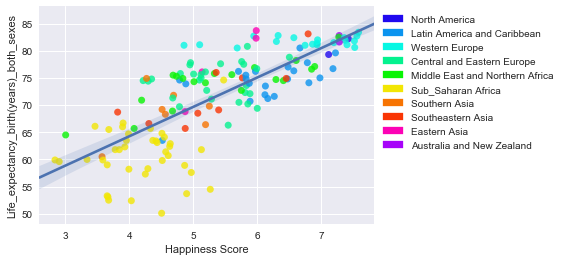

In [82]:
#Is there a relationship between Happiness Scores and Life Expectancies?
g = sns.regplot(happiness_life_expectancies_2015['Happiness Score'],
                happiness_life_expectancies_2015['Life_expectancy_birth(years)_both_sexes'],
                scatter_kws={'color':list(happiness_life_expectancies_2015['Color'])})
#create custom legend:
blue_patch = mpatches.Patch(color='#2009ef', label='North America')
light_blue_patch = mpatches.Patch(color='#0b94ef', label='Latin America and Caribbean')
aqua_patch = mpatches.Patch(color='#07f7e3', label='Western Europe')
light_green_patch = mpatches.Patch(color='#04f28f', label='Central and Eastern Europe')
green_patch = mpatches.Patch(color='#08f404', label='Middle East and Northern Africa')
yellow_patch = mpatches.Patch(color='#f2e604', label='Sub_Saharan Africa')
orange_patch = mpatches.Patch(color='#f77402', label='Southern Asia')
dark_red_patch = mpatches.Patch(color='#f93504', label='Southeastern Asia')
pink_red_patch = mpatches.Patch(color='#fc02b5', label='Eastern Asia')
purple_red_patch = mpatches.Patch(color='#a703f9', label='Australia and New Zealand')

plt.legend(handles=[blue_patch,light_blue_patch,aqua_patch,light_green_patch,
                   green_patch,yellow_patch,orange_patch,dark_red_patch,
                   pink_red_patch,purple_red_patch],bbox_to_anchor=(1, 1))
plt.show()

In [85]:
# It looks like there is a strong relationship, based upon the simple linear regression 
# run above! When we run the pearson corr coeff, we see that there is a strong correlation:
r, p_value = scipy.stats.pearsonr(happiness_life_expectancies_2015['Happiness Score'],happiness_life_expectancies_2015['Life_expectancy_birth(years)_both_sexes'])
r, p_value

(0.76512374737843303, 1.7721815748087781e-30)

In [86]:
# Also note that the Western European, North American, and Asia-Pacific countries have the
# highest life expectancies and happiness ratings, while the Sub-Saharan African 
# countries generally have the lowest life expectancies and happiness ratings. 

# Is this finding that surprising, given that 'Health' was a factor used in determining the 
# Happiness Scores? Probably not all that surprising. But it's ncie to see where each of the
# regions of the world fit on the regression curve. 

In [ ]:
# Next we will examine how Total Hours Worked/Year is related to Happiness Scores. This
# factor is less obviously related to happiness (i.e., it was not used to calculate Happines
# Scores).

